## Import TensorFlow and Setup GPU Devices

In [1]:
import tensorflow as tf

# Ensure TensorFlow sees the GPUs
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print(f'{len(physical_devices)} Physical GPUs detected')
else:
    print("No GPUs available, using CPU instead")


2024-06-28 13:57:10.980070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 13:57:10.980165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 13:57:11.126673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs detected


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Preprocessing

In [3]:
# Load data from CSV files
train_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
test_df = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')

# Preprocess text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['full_text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['full_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['full_text'])

max_len = 1000
vocab_size = len(tokenizer.word_index) + 1

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(train_df['score'].values.reshape(-1, 1)).flatten()

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_pad, y_train_scaled, test_size=0.2, random_state=42)

## Define and Compile Model

In [4]:
def lstm_attention_model(max_len, vocab_size, embedding_dim=256):
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
    attention = Attention()([lstm_out, lstm_out])
    attention = Dropout(0.25)(attention)
    
    lstm_out = LSTM(64)(attention)
    outputs = Dense(1, activation='tanh')(lstm_out)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model within a strategy scope for GPU usage
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = lstm_attention_model(max_len, vocab_size, embedding_dim=256)
    model.compile(optimizer='adam', loss='mse')

## Save Block Diagram of the Model


# Model Summary



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1000, 256) │ 17,523,712 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1000, 256) │    394,240 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1000, 256) │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1000, 256) │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     82,176 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,000,193 (68.67 MB)

 Trainable params: 18,000,193 (68.67 MB)

 Non-trainable params: 0 (0.00 B)

None


# Block Diagram



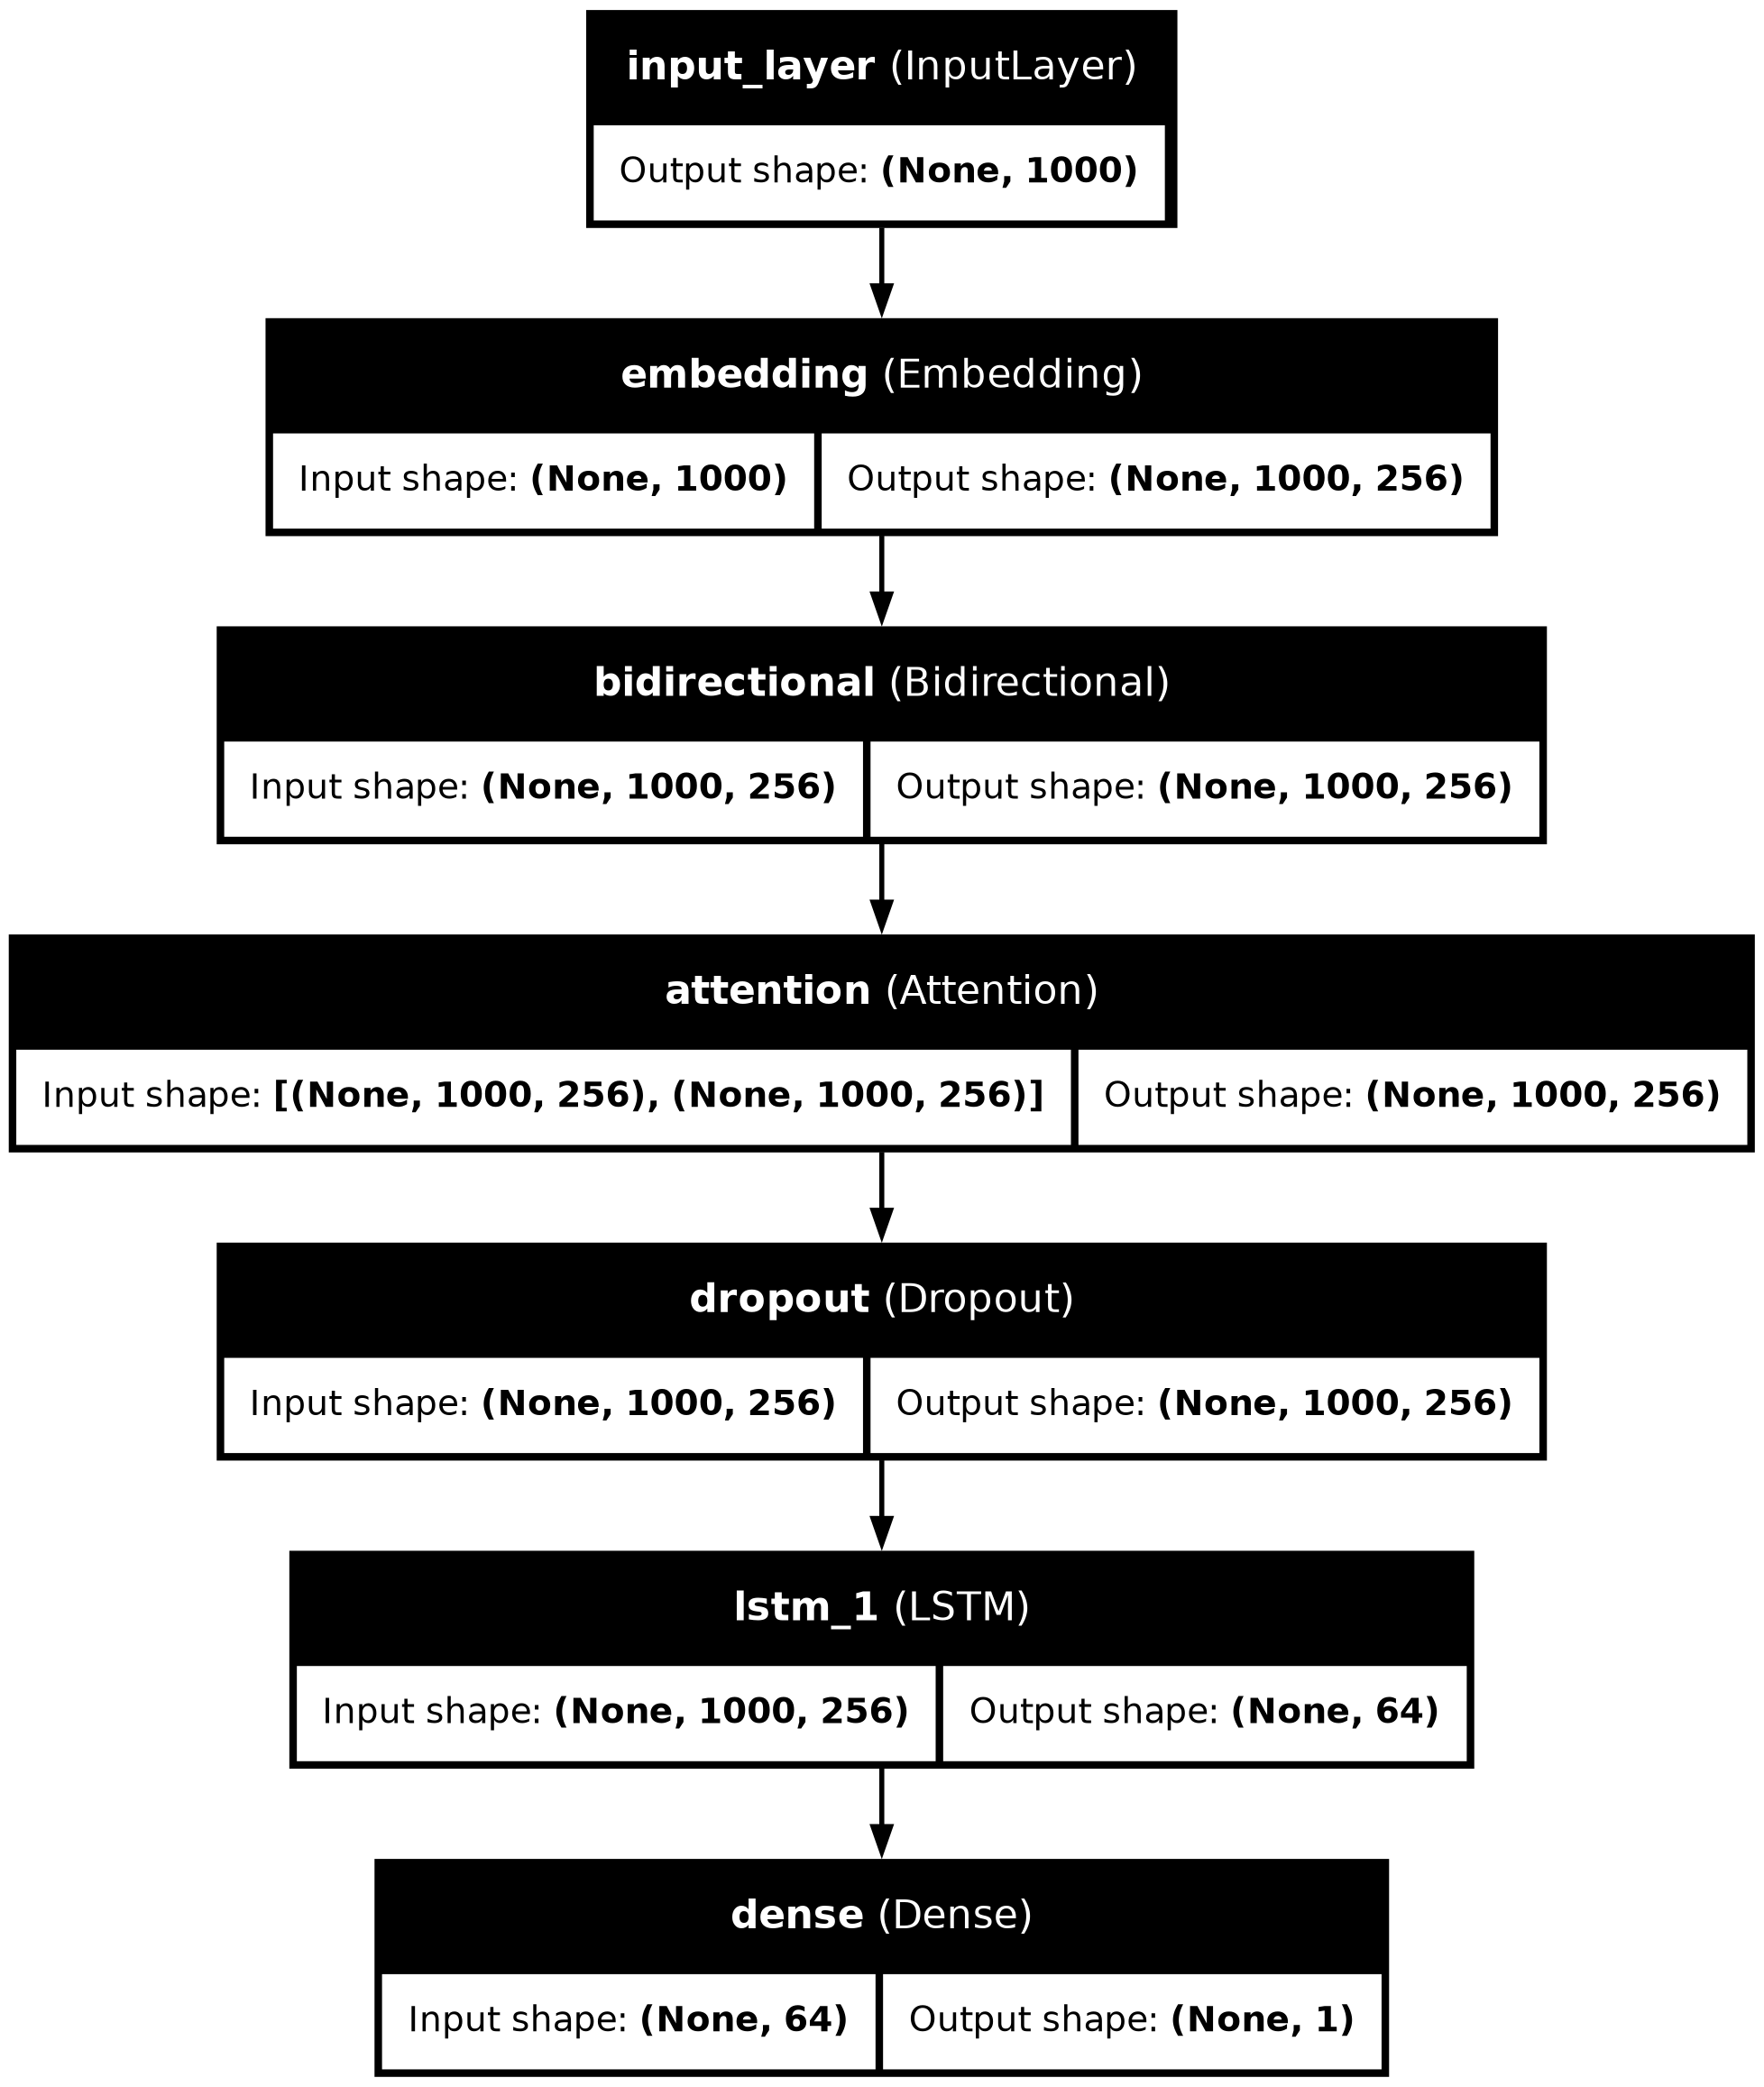

In [5]:
print("\n# Model Summary\n")
print(model.summary())

print("\n\n# Block Diagram\n")
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Define Callbacks

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stopping= EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model1.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

## Train the Model & Plot Training History

In [7]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=128, verbose=1, shuffle=True, callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 43s 349ms/step - loss: 0.6352 - val_loss: 0.5023 - learning_rate: 0.0010
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 37s 342ms/step - loss: 0.4437 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 333ms/step - loss: 0.3199 - val_loss: 0.4131 - learning_rate: 0.0010
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 333ms/step - loss: 0.2798 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 36s 333ms/step - loss: 0.2362 - val_loss: 0.4196 - learning_rate: 0.0010


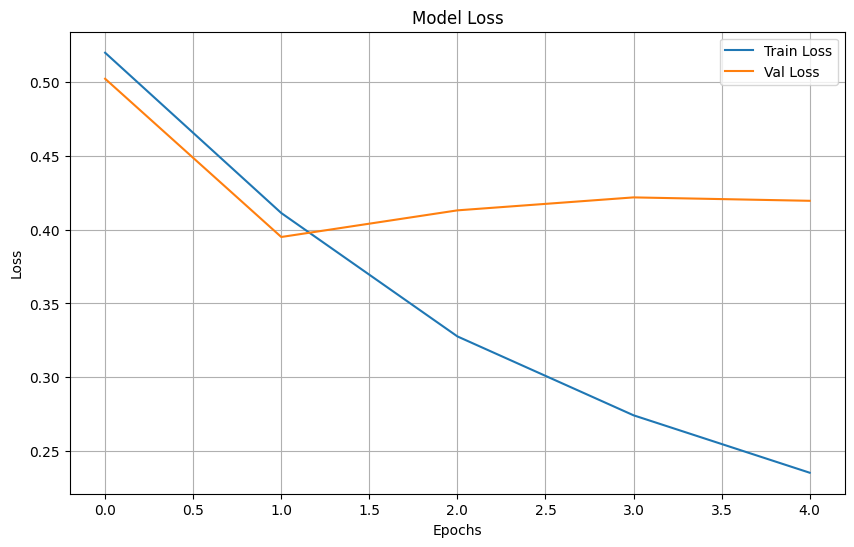

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

## Calculate Kappa Score

In [11]:
from sklearn.metrics import cohen_kappa_score

# Generate predictions for the validation set
predictions = model.predict(X_val)
rounded_predictions = predictions.round().astype(int)

# Transform y_val back to original scale
y_val_inverse = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

k_score = cohen_kappa_score(y_val_inverse, rounded_predictions, weights='quadratic')
print(f"Kappa score is: {k_score}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step
Kappa score is: 0.10822409901252295


## Predict on Test data

In [10]:
predictions_lstm_scaled = model.predict(X_test_pad)
predictions_lstm = scaler.inverse_transform(predictions_lstm_scaled).flatten()

x = np.round(predictions_lstm)
# Round predictions and convert to int
rounded_predictions = x.astype(int)

# Create submission DataFrame
submission_df = pd.DataFrame({'essay_id': test_df['essay_id'], 'score': rounded_predictions})
submission_df.to_csv('submission.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
